Detected number of lanes: 10


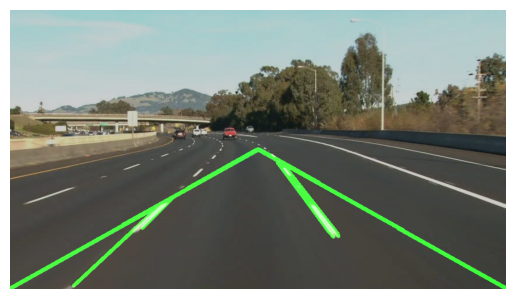

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the input traffic photo
def read_image(image_path):
    image = cv2.imread(image_path)
    return image

# Step 2: Apply Gaussian Blur
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Step 3: Define Region of Interest
def region_of_interest(image):
    height, width = image.shape[:2]
    mask = np.zeros_like(image)

    # Define the region (triangle for simplicity)
    polygon = np.array([[
        (0, height),  # Bottom-left
        (width, height),  # Bottom-right
        (width // 2, height // 2)  # Top-center
    ]], dtype=np.int32)

    cv2.fillPoly(mask, polygon, (255, 255, 255))
    return cv2.bitwise_and(image, mask)

# Step 4: Canny Edge Detection
def apply_canny(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

# Step 5: Hough Transform for Line Detection
def detect_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)

# Step 6: Draw Lines on the Original Image
def draw_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return cv2.addWeighted(image, 0.8, line_image, 1, 1)

# Step 7: Count Lanes Based on Scan Lines
def count_lanes(image, lines):
    height, _ = image.shape[:2]
    lane_positions = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if y1 > height // 2 and y2 > height // 2:  # Only consider lines in the lower half
                lane_positions.append((x1, x2))
    
    # Sort and merge close positions to count lanes
    lane_positions = sorted(set([min(pos) for pos in lane_positions]))
    return len(lane_positions)

# Main Function
def process_image(image_path):
    image = read_image(image_path)
    blurred = apply_gaussian_blur(image)
    roi = region_of_interest(blurred)
    edges = apply_canny(roi)
    lines = detect_lines(edges)

    lane_count = count_lanes(image, lines)
    print(f"Detected number of lanes: {lane_count}")

    # Draw lines and display
    result = draw_lines(image, lines)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Provide the path to your image
process_image('D:\\FinalProject\\trafik.jpeg')



In [61]:
def detect_edge_points_lower_half(image, num_scan_lines=10, li=3):
    """
    Detect edge points using scan lines focused on the lower half of the image.
    
    Args:
    - image: Input grayscale image.
    - num_scan_lines: Number of horizontal scan lines.
    - li: Neighborhood parameter (Li) for edge strength calculation.
    
    Returns:
    - edge_points: List of detected edge points (x, y) for each scan line.
    """
    height, width = image.shape
    edge_points = []
    
    # Define the region of interest (lower half of the image)
    lower_half_start = height // 2
    scan_line_spacing = (height - lower_half_start) // num_scan_lines

    # Loop through each scan line in the lower half
    for line_idx in range(num_scan_lines):
        y = min(lower_half_start + scan_line_spacing * line_idx, height - 1)  # Ensure y is within bounds
        edge_strengths = []

        # Check if `li` is too large for the image width
        if li * 2 >= width:
            raise ValueError(f"Neighborhood size `li={li}` is too large for image width {width}.")

        # Calculate edge strength for each pixel on the scan line
        for x in range(li, width - li):
            left_sum = sum(image[y, x - k] for k in range(1, li + 1))
            right_sum = sum(image[y, x + k] for k in range(1, li + 1))
            edge_strength = -left_sum + right_sum
            edge_strengths.append(edge_strength)

        # Detect maximum and minimum edge strength points
        if edge_strengths:
            max_idx = np.argmax(edge_strengths) + li
            min_idx = np.argmin(edge_strengths) + li
            edge_points.append((max_idx, y))
            edge_points.append((min_idx, y))

    return edge_points


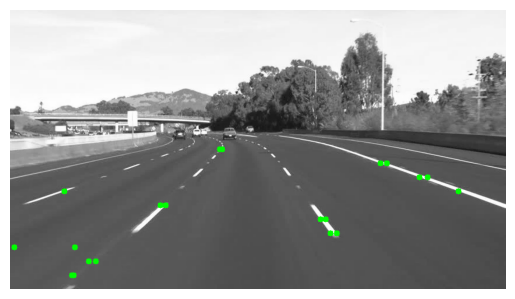

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def visualize_edge_points(image, edge_points):
    """
    Visualize the detected edge points on the image.
    """
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for x, y in edge_points:
        cv2.circle(output_image, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


# Main Function
if __name__ == "__main__":
    # Load grayscale image
    image_path = "D:\\FinalProject\\trafik.jpeg"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Detect edge points
    edge_points = detect_edge_points_lower_half(image, num_scan_lines=10, li=3)

    # Visualize results
    visualize_edge_points(image, edge_points)


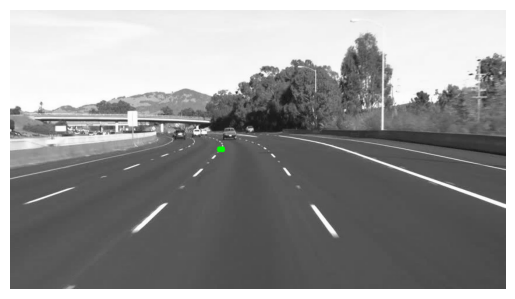

In [63]:
if __name__ == "__main__":
    # Load grayscale image
    image_path = "D:\FinalProject\\trafik.jpeg"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Detect edge points in the lower half
    edge_points = detect_edge_points_lower_half(image, num_scan_lines=1, li=3)

    # Visualize results
    visualize_edge_points(image, edge_points)


In [64]:
def merge_similar_lines(lane_lines, rho_threshold=150, theta_threshold=0.8):
    """
    Merge similar lines to avoid multiple overlapping detections.
    
    Args:
    - lane_lines: List of lane lines as tuples (rho, theta).
    - rho_threshold: Maximum distance (in pixels) to consider lines as similar.
    - theta_threshold: Maximum angular difference (in radians) to consider lines as similar.

    Returns:
    - merged_lines: List of merged lane lines as tuples (rho, theta).
    """
    if not lane_lines:
        return []

    merged_lines = []
    used = [False] * len(lane_lines)

    for i, (rho1, theta1) in enumerate(lane_lines):
        if used[i]:
            continue

        # Start merging with the current line
        rho_sum, theta_sum, count = rho1, theta1, 1
        used[i] = True

        for j, (rho2, theta2) in enumerate(lane_lines):
            if used[j]:
                continue

            # Check similarity
            if abs(rho1 - rho2) < rho_threshold and abs(theta1 - theta2) < theta_threshold:
                rho_sum += rho2
                theta_sum += theta2
                count += 1
                used[j] = True

        # Add the averaged line to merged_lines
        merged_lines.append((rho_sum / count, theta_sum / count))

    return merged_lines


def vote_for_lane_lines_with_merging(edge_points, image_shape, num_bins=100, rho_threshold=20, theta_threshold=0.1):
    """
    Predict all lane lines based on voting in parameter space and merge similar lines.
    
    Args:
    - edge_points: List of detected edge points (x, y).
    - image_shape: Shape of the image (height, width).
    - num_bins: Number of bins for the parameter space.
    - rho_threshold: Threshold to merge similar lines (in pixels).
    - theta_threshold: Threshold to merge similar angles (in radians).

    Returns:
    - merged_lines: List of merged lane lines as tuples (rho, theta).
    - accumulator: Accumulator matrix for visualization.
    """
    height, width = image_shape[:2]
    diag = int(np.sqrt(height**2 + width**2))  # Maximum distance for rho
    rho_bins = np.linspace(-diag, diag, num_bins)
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, num_bins)

    # Accumulator for votes in (rho, theta) space
    accumulator = np.zeros((len(rho_bins), len(theta_bins)))

    # Populate accumulator by voting
    for x, y in edge_points:
        for theta_idx, theta in enumerate(theta_bins):
            rho = x * np.cos(theta) + y * np.sin(theta)
            rho_idx = np.argmin(np.abs(rho_bins - rho))
            accumulator[rho_idx, theta_idx] += 1

    # Identify local maxima in the accumulator
    lane_lines = []
    threshold = np.max(accumulator) * 0.5  # Take lines with votes > 50% of max
    for rho_idx, theta_idx in zip(*np.where(accumulator > threshold)):
        lane_lines.append((rho_bins[rho_idx], theta_bins[theta_idx]))

    # Merge similar lines
    merged_lines = merge_similar_lines(lane_lines, rho_threshold, theta_threshold)

    return merged_lines, accumulator


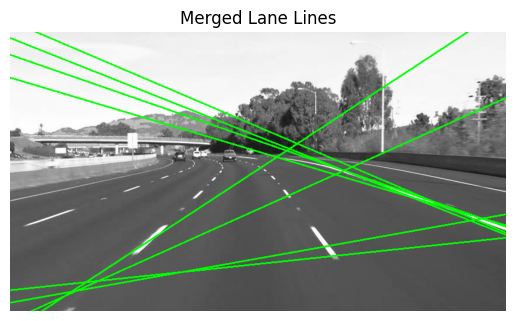

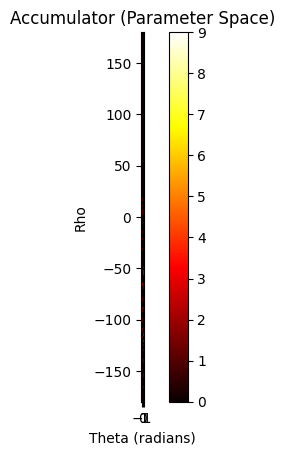

In [68]:
if __name__ == "__main__":
    # Load grayscale image
    image_path = "D:\FinalProject\\trafik.jpeg"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Detect edge points in the lower half
    edge_points = detect_edge_points_lower_half(image, num_scan_lines=100, li=5)

    # Predict and merge lane lines
    merged_lines, accumulator = vote_for_lane_lines_with_merging(
        edge_points, image.shape, num_bins=180, rho_threshold=30, theta_threshold=0.05
    )

    # Draw and visualize merged lane lines
    output_image = draw_lane_lines(image, merged_lines)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Merged Lane Lines")
    plt.show()

    # Optional: Visualize accumulator heatmap
    plt.imshow(accumulator, cmap='hot', interpolation='nearest', extent=(-np.pi / 2, np.pi / 2, -accumulator.shape[0], accumulator.shape[0]))
    plt.title("Accumulator (Parameter Space)")
    plt.xlabel("Theta (radians)")
    plt.ylabel("Rho")
    plt.colorbar()
    plt.show()
